# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
import os
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img1, img2):
    img1 = TF.to_pil_image(img1, mode='L')
    img2 = TF.to_pil_image(img2, mode='L')
    plt.subplot(121)
    plt.imshow(img1)
    plt.subplot(122)
    plt.imshow(img2)
    plt.show()    
    
def show_plot(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    train_file = './train_unit_ids.txt'
    val_file = './val_unit_ids.txt'
    data_dir = '../boto3/pair_madori'
    checkpoint_dir = './checkpoint'
    
    batch_size = 16
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class MadoriDataset(Dataset):
    
    def _prepare(self):
        data_file = Config.train_file if self.train else Config.val_file
        with open(data_file, 'r') as f:
            lines = f.readlines()
        f.close()
        self.unit_paths = [os.path.join(Config.data_dir, line.strip()) for line in lines]
        
    def __init__(self, img_size=(256, 256), train=True):
        self.train = train
        self.img_size = (256, 256)
        self._prepare()
        
    def __len__(self):
        return len(self.unit_paths)
    
    def _resize(self, img):
        w, h = img.size
        if w < h:
            a = 256.0 / h
            b = int(w * a)
            img = img.resize((b, 256), Image.BILINEAR)
        else:
            a = 256.0 / w
            b = int(h * a)
            img = img.resize((256, b), Image.BILINEAR)
        return img
    
    def _pad(self, img):
        w, h = img.size
        img = TF.pad(img, (0,0,256-w,0), padding_mode='edge') if h == 256 else \
               TF.pad(img, (0,0,0,256-h), padding_mode='edge')
        
        if img.size != self.img_size:
            print('|-'*20, img.size, (w, h)) # (97, 256) (97, 249)
        return img
    
    def _transform(self, img):
        return self._pad(self._resize(img))
    
    def _aug_img(self, image):
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([90, 180, 270]))
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        return image
    
    def _select_img_path(self, unit_path, not_equal_to=None):
        img_path = os.path.join(unit_path, random.choice(os.listdir(unit_path)))
        if not_equal_to:
            while img_path == not_equal_to:
                img_path = os.path.join(unit_path, random.choice(os.listdir(unit_path)))
        return img_path
    
    def __getitem__(self, idx):
        unit_path1 = self.unit_paths[idx]
        
        img1_path = self._select_img_path(unit_path1)
        img1 = self._transform(Image.open(img1_path).convert('L'))
        
        label = random.randint(0, 1)
        if label:
            # choose different floorplan
            unit_path2 = unit_path1
            while unit_path2 == unit_path1:
                unit_path2 = random.choice(self.unit_paths)            
            img2 = self._transform(Image.open(self._select_img_path(unit_path2)).convert('L'))
        else:
            # choose similar floorplan by augmentation
            img2_path = self._select_img_path(unit_path1, not_equal_to=img1_path)
            img2 = self._transform(Image.open(img2_path).convert('L'))
            
        img1, img2 = TF.to_tensor(self._aug_img(img1)), TF.to_tensor(self._aug_img(img2))
        return img1, img2, torch.from_numpy(np.array([label],dtype=np.float32))

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])
tensor([1.])


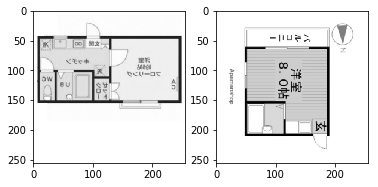

tensor([0.])


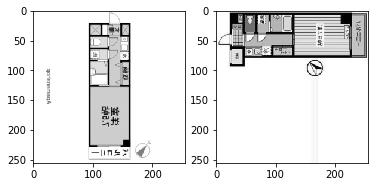

tensor([0.])


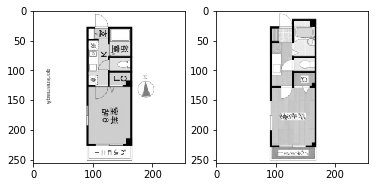

In [5]:
dset_loader = DataLoader(MadoriDataset(), 
                           batch_size=Config.batch_size, 
                           shuffle=True)

for i, batch in enumerate(dset_loader):
    img1, img2, label = batch
    print(img1.size(), img2.size())
    for k in range(3):
        print(label[k])
        imshow(img1[k], img2[k])
    break

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*256*256, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - 
                                        euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(MadoriDataset(), 
                                shuffle=True,
                                batch_size=Config.batch_size)

val_dataloader = DataLoader(MadoriDataset(train=False), 
                                shuffle=False,
                                batch_size=Config.batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
train_loss_history, val_loss_history = [], []
lowest_epoch_train_loss = lowest_epoch_val_loss = float('inf')

In [ ]:
for epoch in tqdm(range(Config.train_number_epochs)):
    # training
    net.train()
    epoch_train_loss = 0
    for batch_no, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        batch_train_loss = criterion(output1,output2,label)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()
        optimizer.step()
    epoch_train_loss /= (batch_no + 1)
    print(f'Epoch {epoch} training loss {epoch_train_loss}')
    train_loss_history.append(epoch_train_loss)
    
    # validation
    net.eval()
    epoch_val_loss = 0
    for batch_no, data in enumerate(val_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        batch_val_loss = criterion(output1,output2,label)
        epoch_val_loss += batch_val_loss
    epoch_val_loss /= (batch_no + 1)
    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        torch.save(net.state_dict(), f'{Config.checkpoint_dir}/{epoch}.pth')
    print(f'Epoch {epoch} validation loss {epoch_val_loss}')
    val_loss_history.append(epoch_val_loss)

In [ ]:
show_plot(train_loss_history, val_loss_history)

## Some simple testing

In [ ]:
epoch_test = 0
net = SiameseNetwork().to(device)
net.load_state_dict(torch.load(f'{Config.checkpoint_dir}/{epoch_test}.pth'))
test_dataloader = DataLoader(MadoriDataset(Config.test_dir), 
                                shuffle=False,
                                batch_size=Config.batch_size)

In [ ]:
net.eval()
for batch_no, data in enumerate(test_dataloader):
    img0, img1, label = data
    img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
    output1,output2 = net(img0,img1)
    batch_test_loss = criterion(output1,output2,label)

    for k in range(3):
        print(f'label: {label[k]}, pred: {batch_test_loss[k].item()}')
        imshow(img1[k], img2[k])
    break